In [ ]:
#ignore annoying deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Logistic Regression in Python!


## Introduction

**Logistic regression** is a form of regression analysis in which a logistic function is used to model a dependent (outcome) variable that has two possible values, which are are labeled as *1* and *0*. These values are used to represent binary outcomes such as pass/fail, win/lose, yes/no, male/female, etc. Logistic regression can hence be used as a *binary classifier*.

A logistic regression model estimates the *log-odds* (i.e., *the **log**arithm of the **odds***, also known as the *log likelihood*) of the outcome labeled as *1* using a linear combination of one or more independent (predictor) variables, each of which is either a binary variable or a continuous variable. Thus, although the dependent (outcome) variable in binary logistic regression is a zero-or-one variable, the logistic regression estimates the odds -- as a continuous variable -- that the dependent variable is equal to *1*. In correspondence with the above discussion, a logistic regression model has the form:

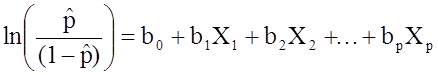

The unit of measurement for the log-odds scale is called a *logit* (from ***log**istic un**it***), hence the name *logistic regression*. Given the form of the equation shown above, the estimated probability *p* of the outcome labeled as *1* can be recovered from the logit via the exponential function (i.e., the inverse of the natural logarithm):

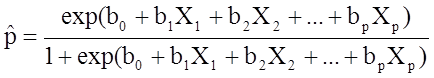

The relationship between *p* and the logit of *p* is shown below:

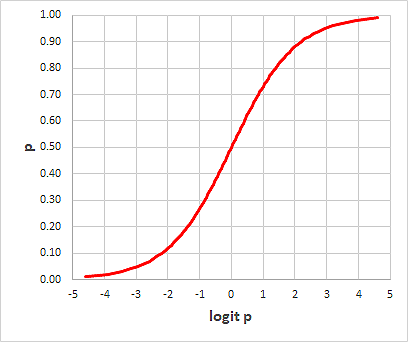

Using these techniques, we can thus transform the continuous output of the linear regression model (defined on $-\infty \le logit(p) \le \infty$) to a binary response ($0 \le p \le 1$).

## Load Libraries and Data

In this lesson, we'll be using the *Affairs* data that we used in a few of our previous lessons to learn how to perform a logistic regression analysis in Python. We'll be using the `linear_model` and `metrics` packages from **scikit-learn** to actually estimate our logistic regression models.

In [ ]:
#import libraries
import pandas as pd
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.model_selection as ms

#load the Affairs dataset from a CSV file, and assign it to a pandas dataframe
df = pd.read_csv('affairs.csv')

#view the first 10 rows of data in the dataframe
df.head(10)

## Variable Definitions

As a brief refresher, the variables contained in the data set are:

#### religious
The extent to which each woman is religious.

#### occupation
The level of social status of each woman's occupation.

#### occupation_husb
The level of social status of the occupation of each woman's husband.

#### log_children
Each woman's number of children (log transformed).

#### log_age
Each woman's age in years (log transformed).

#### log_yrs_married
The number of years that each woman has been married (log transformed).

#### log_educ
Each woman's years of education (log transformed).

##### exp_rate_marriage
How happy each woman is with her marriage (exponentially transformed).

#### affairs
A measure of time that each woman has spent in extramarital affairs.

#### had_an_affair
Indicates whether each woman had at least one affair.

#### number_of_lovers
The number of men with whom each woman had affairs.

#### times_per_lover
The average number of times that a woman had sexual relations with each lover in an affair.

## Class Imbalance
For this lesson, our primary dependent (outcome) variable will be *had_an_affair*. This is a binary variable for which values of *1* indicate that a woman had at least one extramarital affair, while values of *0* indicate that a woman did not have any extramarital affairs. Our task is thus to use logistic regression to predict whether a woman had an affair or not. Let's begin by examining the *had_an_affair* variable a bit more closely:

In [ ]:
#show descriptives for the 'had_an_affair' variable
print(df.had_an_affair.describe())

#show number of 'affair' cases
print('Number of affairs cases: ' + str(df[df['had_an_affair'] == 1].shape[0]))

As shown above, the mean value of *had_an_affair* is approximately 0.185. Based on the coding scheme for this variable, this indicates that only 18.5% of the women in the data set (i.e., 978 women) had at least one extramarital affair. Since the number of cases for women who had no affairs is far greater than the number of cases for women who did have affairs, we have a substantial problem with **class imbalance** in our dependent variable. In logistic regression models, class imbalnce in our training data affects the estimate of the regression constant (intercept), which skews all of the predicted probabilities, and subsequently compromises the accuracy of our predictions.

We can correct the problem with class imbalance by using Bernoulli sampling to extract a subset of *did not have an affair* cases that is equal in size to the number of cases in the *did have an affair* class:

In [ ]:
#create a new data frame that contains all of the 'did not have an affair' cases
df_no_affairs = df[df['had_an_affair'] == 0].copy()

#create a new data frame that contains all of the 'did have an affair' cases
df_affairs = df[df['had_an_affair'] == 1].copy()

#use Bernoulli sampling to get a two-dimensional array that contains the indexes of the rows that will comprise the sample
indexes = ms.train_test_split(range(df_no_affairs.shape[0]), test_size = df_affairs.shape[0])

#define the sample of 'did not have an affair' cases
sample = df_no_affairs.iloc[indexes[1],:]

#create a balanced data set by merging the sample with the collection of 'did have an affair' cases
df_balanced = df_affairs.append(sample, ignore_index=True)

#examine the 'had_an_affair' variable in the balanced data set
df_balanced.had_an_affair.describe()

As shown above, our balanced data set now contains 1,956 cases. The mean value of 0.50 for *had_an_affair* indicates that exactly half of the cases are for women who did not have any extramarital affairs (coded as *0*), while the other half of the cases are for women who had at least one extramarital affair (coded as *1*).

## Training and Testing Data
Now that we have a balanced data set, we can proceed with subdividing our data set into training and testing sets. This step is critically important -- if a classification model is evaluated using only the data that were used to train the model, then the results will be both biased and overly optimistic for real-world scenarios.

For our purposes, we will create a training set that contains 70% of our data, while the testing set will contain the remaining 30% of the data:

In [ ]:
#compute the size of the testing data set
test_size = int(df_balanced.shape[0] * 0.3) #30% of the data will be used for testing

#use Bernoulli sampling to get a two-dimensional array that contains the indexes of the rows that will comprise the training and testing data sets
indexes = ms.train_test_split(range(df_balanced.shape[0]), test_size = test_size)

#define the training data set
training = df.iloc[indexes[0],:]

#define the testing data set
testing = df.iloc[indexes[1],:]

# Estimate the Logistic Regression Model
Next, we'll use our **training data** to estimate the logistic regression model. For our purposes, we'll use the following variables as predictors: *religious*, *occupation*, *occupation_husb*, *log_children*, *log_age*, *log_yrs_married*, *log_educ*, and *exp_rate_marriage*.

To estimate the model, we will:
1. Define a logistic regression model object using the `LogisticRegression` method from the scikit-learn `linear_model` package.
2. Fit the linear model using the predictor and outcome variables from our **training** data set:

In [ ]:
#define and fit the logistic regression model
log_mod = linear_model.LogisticRegression() 
log_mod.fit(training[['religious', 'occupation', 'occupation_husb', 'log_children', 'log_age', 'log_yrs_married', 'log_educ', 'exp_rate_marriage']], training['had_an_affair'])

Notice that the configuration of the model object is printed during the estimation process. In our case, all of the values shown are default settings because we didn't specify any custom settings when creating the model object.

Let's take a look at the intercept and parameter estimates for our model:

In [ ]:
#print model intercept and parameter estimates
print(log_mod.intercept_)
print(log_mod.coef_)

Recall that output of a logistic regression model is a set of probabilities for the *1* class. The logistic regression module in *scikit-learn* also computes the complementary probability for each case (i.e., the probability that the case belongs to the *0* class). The class with the highest probability is used as the basis for predicting class membership.

Let's calculate and view the class probability estimates for our **testing** data:

In [ ]:
#calculate probability estimates for the testing data
probs = log_mod.predict_proba(testing[['religious', 'occupation', 'occupation_husb', 'log_children', 'log_age', 'log_yrs_married', 'log_educ', 'exp_rate_marriage']])

#show the first 10 class probability estimates for the testing data
print(probs[:10,:])

The first column contains probability estimates for membership in the *0* (did not have an affair) class, while the second column contains probability estimates for membership in the *1* (had an affair) class.

## Evaluate the Logistic Regression Model
Now that we've computed our class probabilities for the testing data set, we need to transform those probabilities into actual class membership predictions (*1s* and *0s*) before we can evaluate how well the logisitic model works. The simplest way to do this is to use a cutoff threshold of 0.5 -- a probability value greater than or equal to this threshold will indicate the predicted class for each case in the testing set.

In [ ]:
#compute predicted class scores for each case in the testing set
had_an_affair_predicted = pd.DataFrame([1 if i >= 0.5 else 0 for i in probs[:,1]])

#print the first 10 class membership predictons
had_an_affair_predicted.head(10)

The most common way to evaluate the performance of a classifier is to use a **confusion matrix**. A confusion matrix displays the number of correctly and incorrectly classified cases in a table, as shown below:

| | Predicted Positive | Predicted Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Actual Negative**| False Positive | True Negative |   

Here the four elements in the matrix are defined as:    
**True Positive** or **TP** are cases with positive labels (*1s*) which have been correctly classified as positive.     
**True Negative** or **TN** are cases with negative labels (*0s*) which have been correctly classified as negative.  
**False Positive** or **FP** are cases with negative labels which have been incorrectly classified as positive.   
**False Negative** or **FN** are cases with positive labels which have been incorrectly classified as negative.

Additional performance metrice include:

**Accuracy**: Accuracy is the percentage of cases correctly predicted.

**Precision**: Precision is the number of correctly predicted cases for the label value divided by all the cases in the column.

**Recall**: Recall is the percentage of cases of a label value correctly predicted out of all cases that actually have that label value.

**F1**: The F1 statistic is weighted average of precision and recall. Put differently, F1 is a weighted metric for overall model performance.

Let's see how well our logistic regression model is able to predict whether or not a woman will have an affair:

In [ ]:
#define a function that prints a confusion matrix and other performance metrics
def print_metrics(actual, predicted):
    metrics = sklm.precision_recall_fscore_support(actual, predicted)
    conf = sklm.confusion_matrix(actual, predicted)
    print('                 CONFUSION MATRIX')
    print('                 Predicted positive    Predicted negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(actual, predicted))
    print(' ')
    print('           Positive      Negative')
    print('Cases      %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

#show the performance of the logistic regression model on the testing data
print_metrics(testing['had_an_affair'], had_an_affair_predicted)

As you can see, our model is about 70% accurate overall in predicting whether a woman will have an affair. This may not seem particularly good, but human behavior is complex and often very difficult to predict, so 70% accuracy is actually quite good!